In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
ticker = "NVDA"
df = pdr.DataReader(ticker, "stooq", start="2020-01-01")
df = df.sort_index()
pd.concat([df.head(), df.tail()])

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,5.94402,5.97288,5.89330,5.97288,238675161
2020-01-03,5.85308,5.92105,5.82812,5.87724,206634962
2020-01-06,5.78358,5.90707,5.75741,5.90189,264014644
2020-01-07,5.93024,6.01934,5.88510,5.97338,320543948
2020-01-08,5.96910,6.02601,5.92905,5.98467,278402946
2025-09-16,177.00000,177.50000,174.38000,174.88000,140737775
2025-09-17,172.64000,173.20000,168.41000,170.29000,211843817
2025-09-18,173.98000,177.10000,172.96000,176.24000,191763313
2025-09-19,175.77000,178.08000,175.18000,176.67000,237182143


Text(0, 0.5, 'Price')

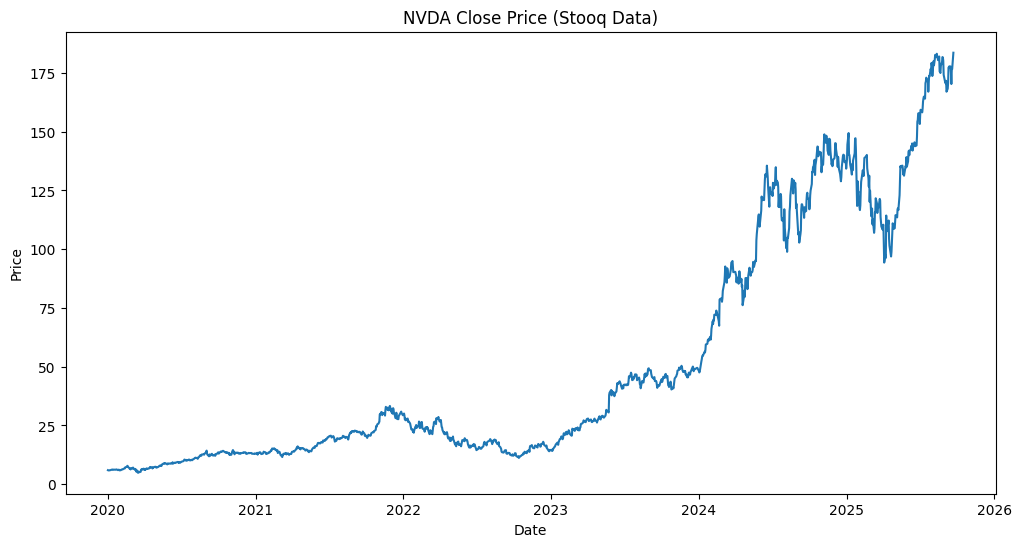

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(df["Close"], label = ticker)
plt.title(f"{ticker} Close Price (Stooq Data)")
plt.xlabel("Date")
plt.ylabel("Price")

In [12]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [13]:
df.Close

Date
2020-01-02   -0.903110
2020-01-03   -0.905013
2020-01-06   -0.904523
2020-01-07   -0.903100
2020-01-08   -0.902875
                ...   
2025-09-16    2.458188
2025-09-17    2.366846
2025-09-18    2.485252
2025-09-19    2.493809
2025-09-22    2.631917
Name: Close, Length: 1438, dtype: float64

In [21]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    #iloc = integer location based indexer
        #lets you select rows/columns by num instead of label
    data.append(df[['Close']].iloc[i:i + seq_length])

data = np.array(data)
data

array([[[-0.90310991],
        [-0.90501317],
        [-0.90452263],
        ...,
        [-0.88924798],
        [-0.88694333],
        [-0.88781576]],

       [[-0.90501317],
        [-0.90452263],
        [-0.90309996],
        ...,
        [-0.88694333],
        [-0.88781576],
        [-0.87840492]],

       [[-0.90452263],
        [-0.90309996],
        [-0.90287529],
        ...,
        [-0.88781576],
        [-0.87840492],
        [-0.87504854]],

       ...,

       [[ 2.54853518],
        [ 2.57540055],
        [ 2.61380808],
        ...,
        [ 2.51530172],
        [ 2.45818794],
        [ 2.36684569]],

       [[ 2.57540055],
        [ 2.61380808],
        [ 2.6010719 ],
        ...,
        [ 2.45818794],
        [ 2.36684569],
        [ 2.48525231]],

       [[ 2.61380808],
        [ 2.6010719 ],
        [ 2.6229622 ],
        ...,
        [ 2.36684569],
        [ 2.48525231],
        [ 2.49380943]]], shape=(1408, 30, 1))

In [46]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).float().to(device)
y_train = torch.from_numpy(data[:train_size, -1 , :]).float().to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).float().to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).float().to(device)

In [47]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [48]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1).to(device)

In [49]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [50]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.3797976076602936
25 0.009322711266577244
50 0.0019335084361955523
75 0.0013717547990381718
100 0.0012051609810441732
125 0.0011505252914503217
150 0.0011259549064561725
175 0.0011023662518709898


In [51]:
model.eval()
y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [52]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [53]:
train_rmse

1.6513186693191528

In [54]:
test_rmse

9.27990436553955

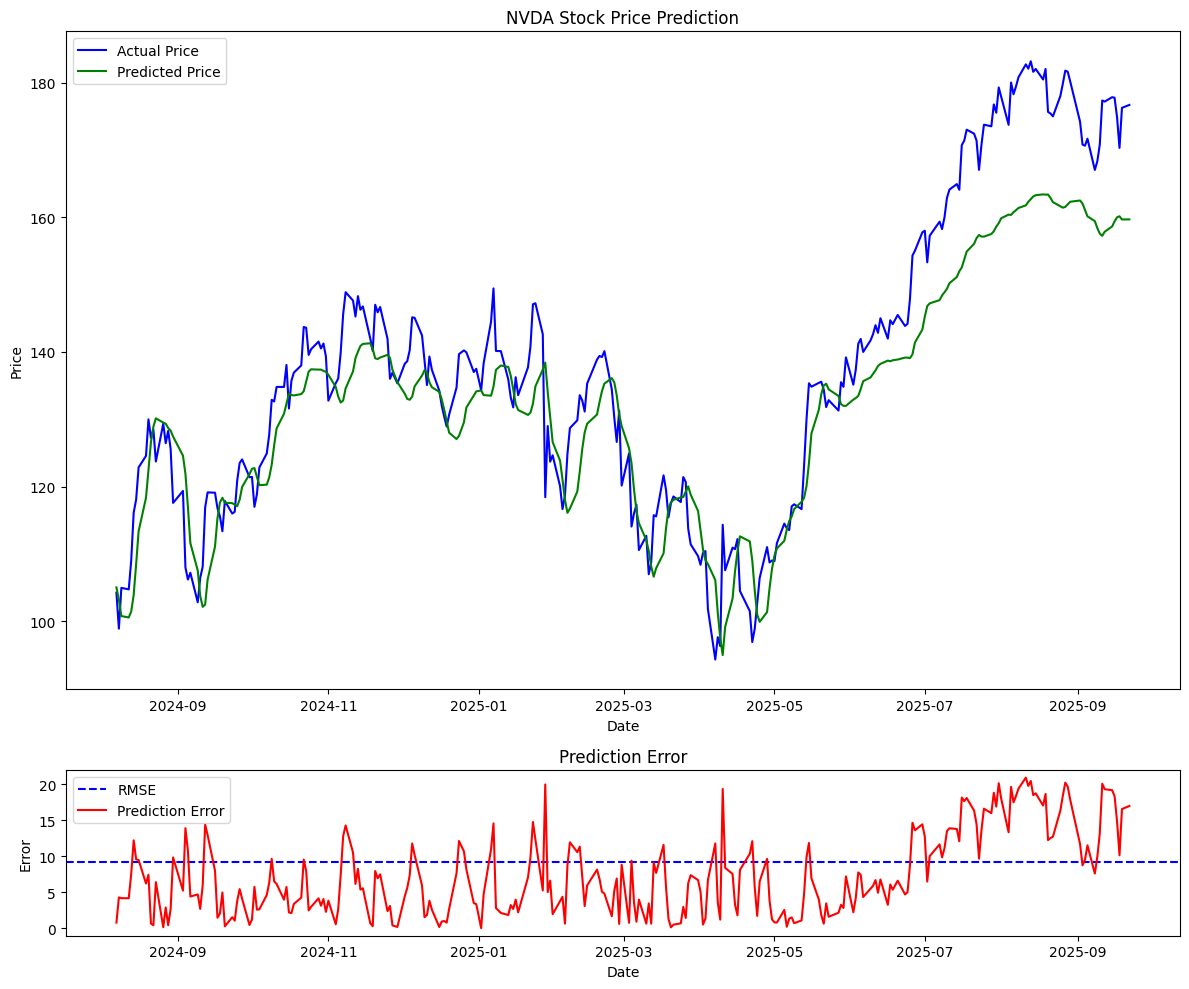

In [56]:
fig = plt.figure(figsize = (12, 10))
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()